### Classification with XGBoost and hyperparameter optimization

In [87]:
# import required libraries for data analysis
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('indian_liver_patient.csv')
data.columns = data.columns.map(str.lower)
data.head()

age  gender  total_bilirubin  direct_bilirubin  alkaline_phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   alamine_aminotransferase  aspartate_aminotransferase  total_protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   albumin  albumin_and_globulin_ratio  dataset  
0      3.3                        0.90        1  
1      3.2                        0.74        1  
2      3.3                        0.89        1  
3      3.4                        1.00        1  
4      2.4                        0.40        1

In [8]:
# Check data types to know if there is null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  579 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [10]:
data.describe(include='all').T

count unique   top freq        mean         std  \
age                         583.0    NaN   NaN  NaN   44.746141   16.189833   
gender                        583      2  Male  441         NaN         NaN   
total_bilirubin             583.0    NaN   NaN  NaN    3.298799    6.209522   
direct_bilirubin            583.0    NaN   NaN  NaN    1.486106    2.808498   
alkaline_phosphotase        583.0    NaN   NaN  NaN  290.576329  242.937989   
alamine_aminotransferase    583.0    NaN   NaN  NaN   80.713551  182.620356   
aspartate_aminotransferase  583.0    NaN   NaN  NaN  109.910806  288.918529   
total_protiens              583.0    NaN   NaN  NaN     6.48319    1.085451   
albumin                     583.0    NaN   NaN  NaN    3.141852    0.795519   
albumin_and_globulin_ratio  579.0    NaN   NaN  NaN    0.947064    0.319592   
dataset                     583.0    NaN   NaN  NaN    1.286449     0.45249   

                             min    25%    50%    75%     max  
age                          4.0   33.0   45.0   58.0    90.0  
gender                       NaN    NaN    NaN    NaN     NaN  
total_bilirubin              0.4    0.8    1.0    2.6    75.0  
direct_bilirubin             0.1    0.2    0.3    1.3    19.7  
alkaline_phosphotase        63.0  175.5  208.0  298.0  2110.0  
alamine_aminotransferase    10.0   23.0   35.0   60.5  2000.0  
aspartate_aminotransferase  10.0   25.0   42.0   87.0  4929.0  
total_protiens               2.7    5.8    6.6    7.2     9.6  
albumin                      0.9    2.6    3.1    3.8     5.5  
albumin_and_globulin_ratio   0.3    0.7   0.93    1.1     2.8  
dataset                      1.0    1.0    1.0    2.0     2.0

What can we see from describe & info ?

* for gender we have 2 unique values - sounds reasonable
* there seems to be extremes for several fields (compare 75% with max) - we will have to fix it
* dataset, our target variable, has 2 values
* albumin_and_globulin_ratio have some missing values those must be handled

### Fixing missing values

In [11]:
# replace missing values with mean
data.albumin_and_globulin_ratio.fillna(data.albumin_and_globulin_ratio.mean(),inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  583 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


#### Exploratory data analysis(EDA)

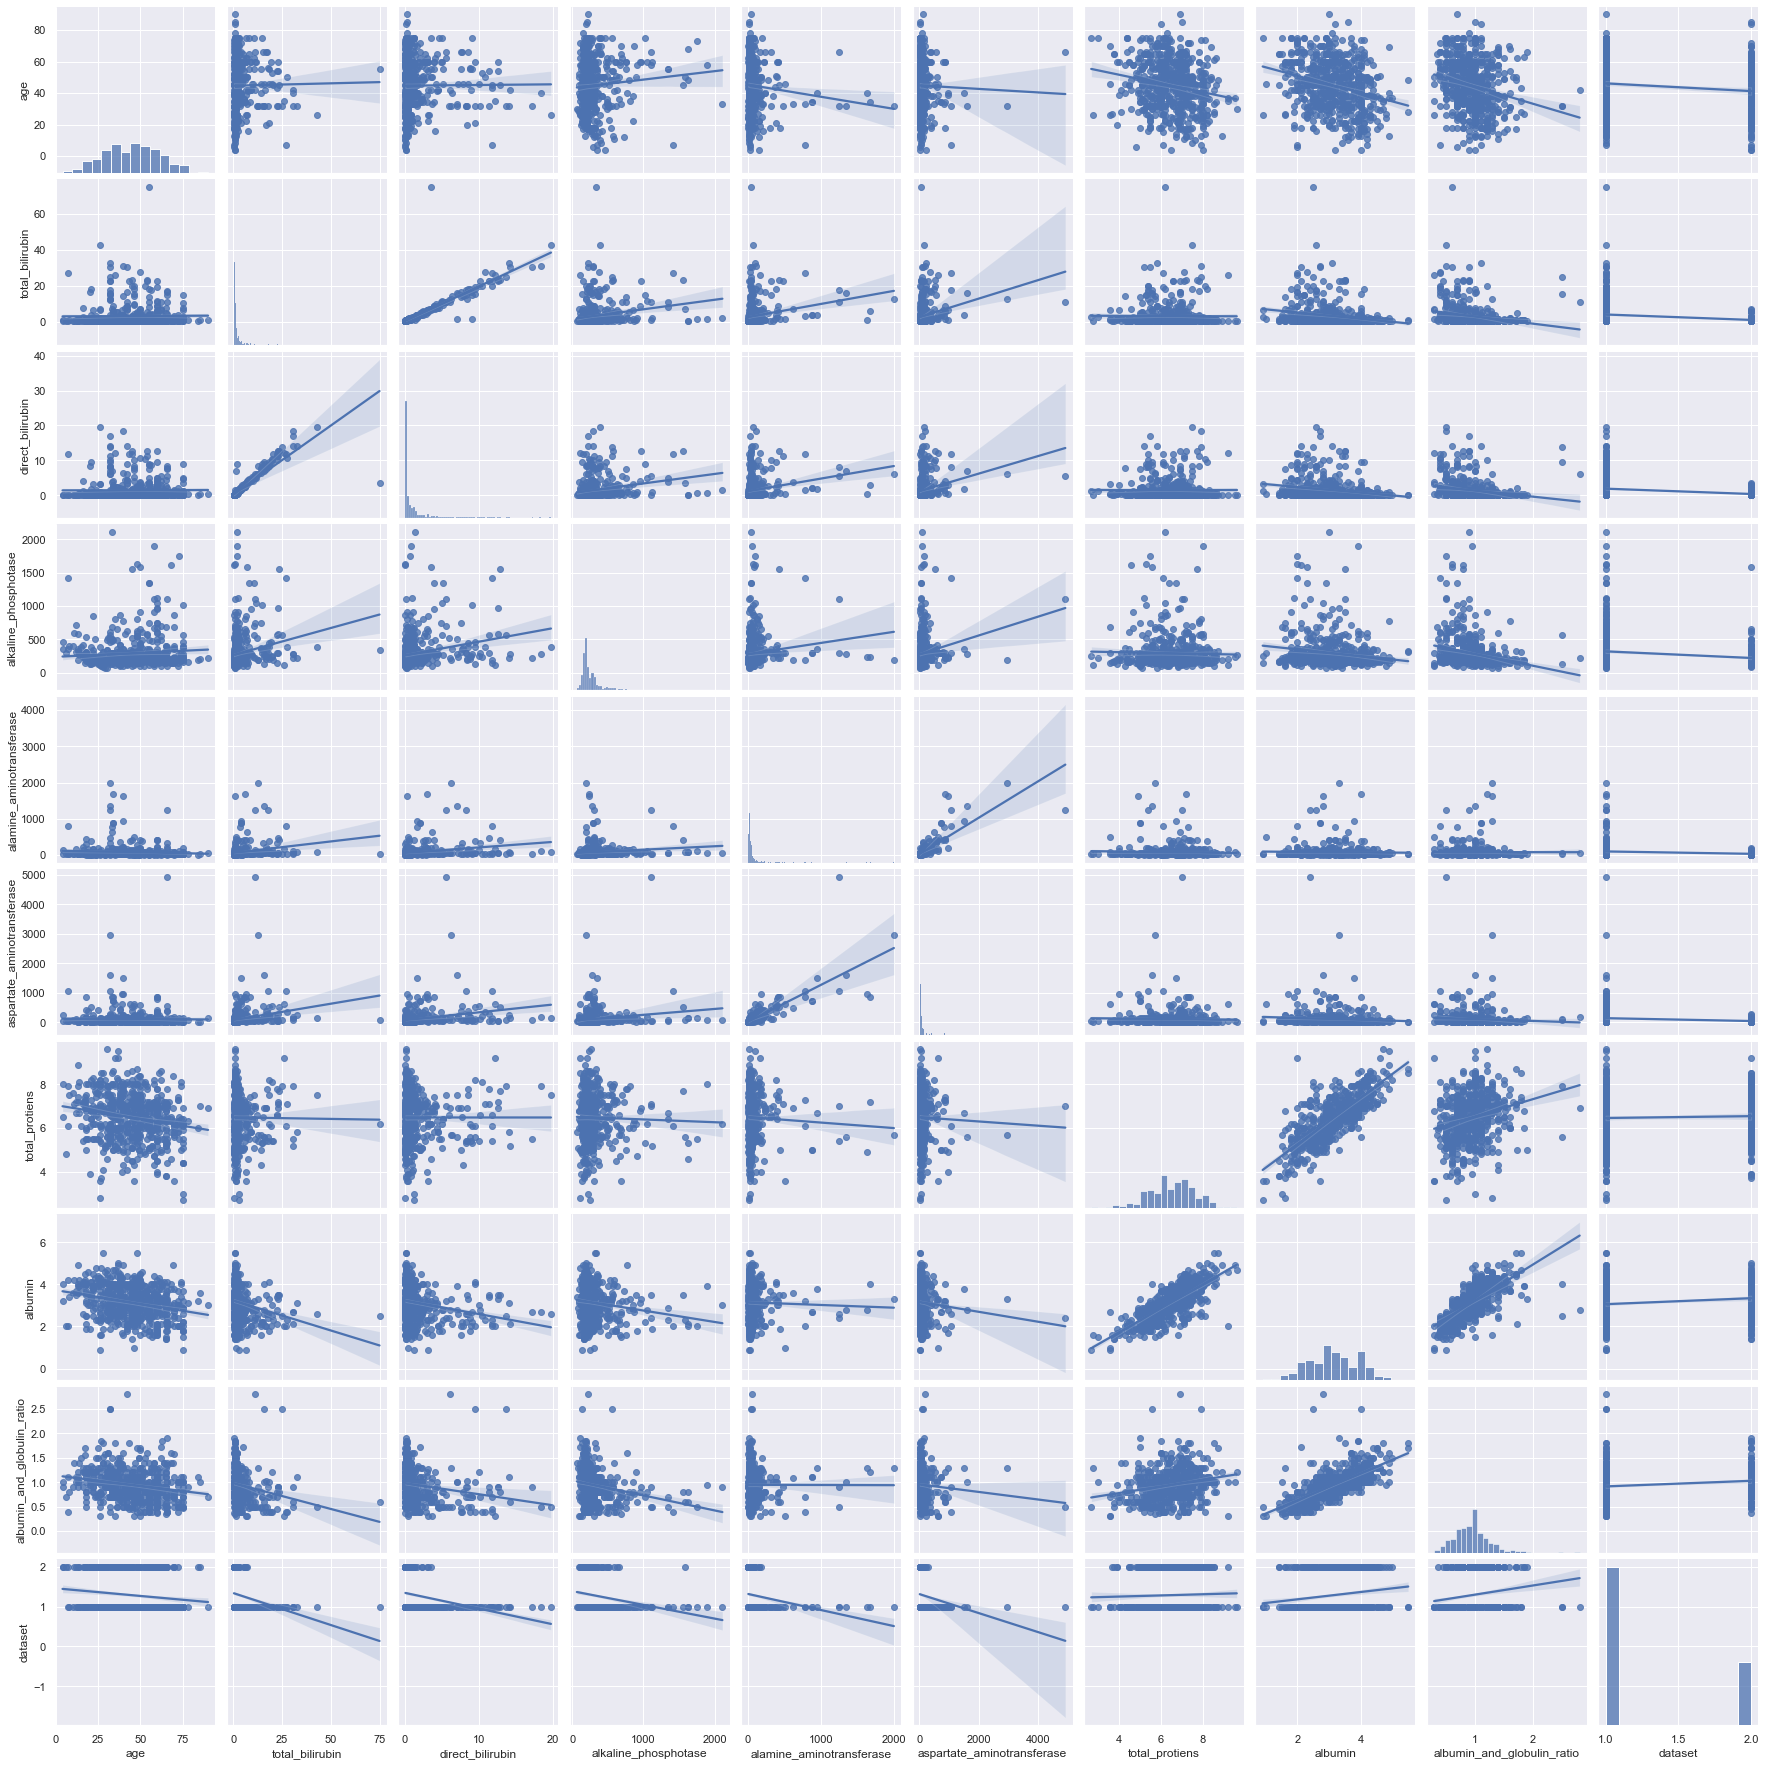

In [14]:
sns.set()
sns.pairplot(data, kind='reg')

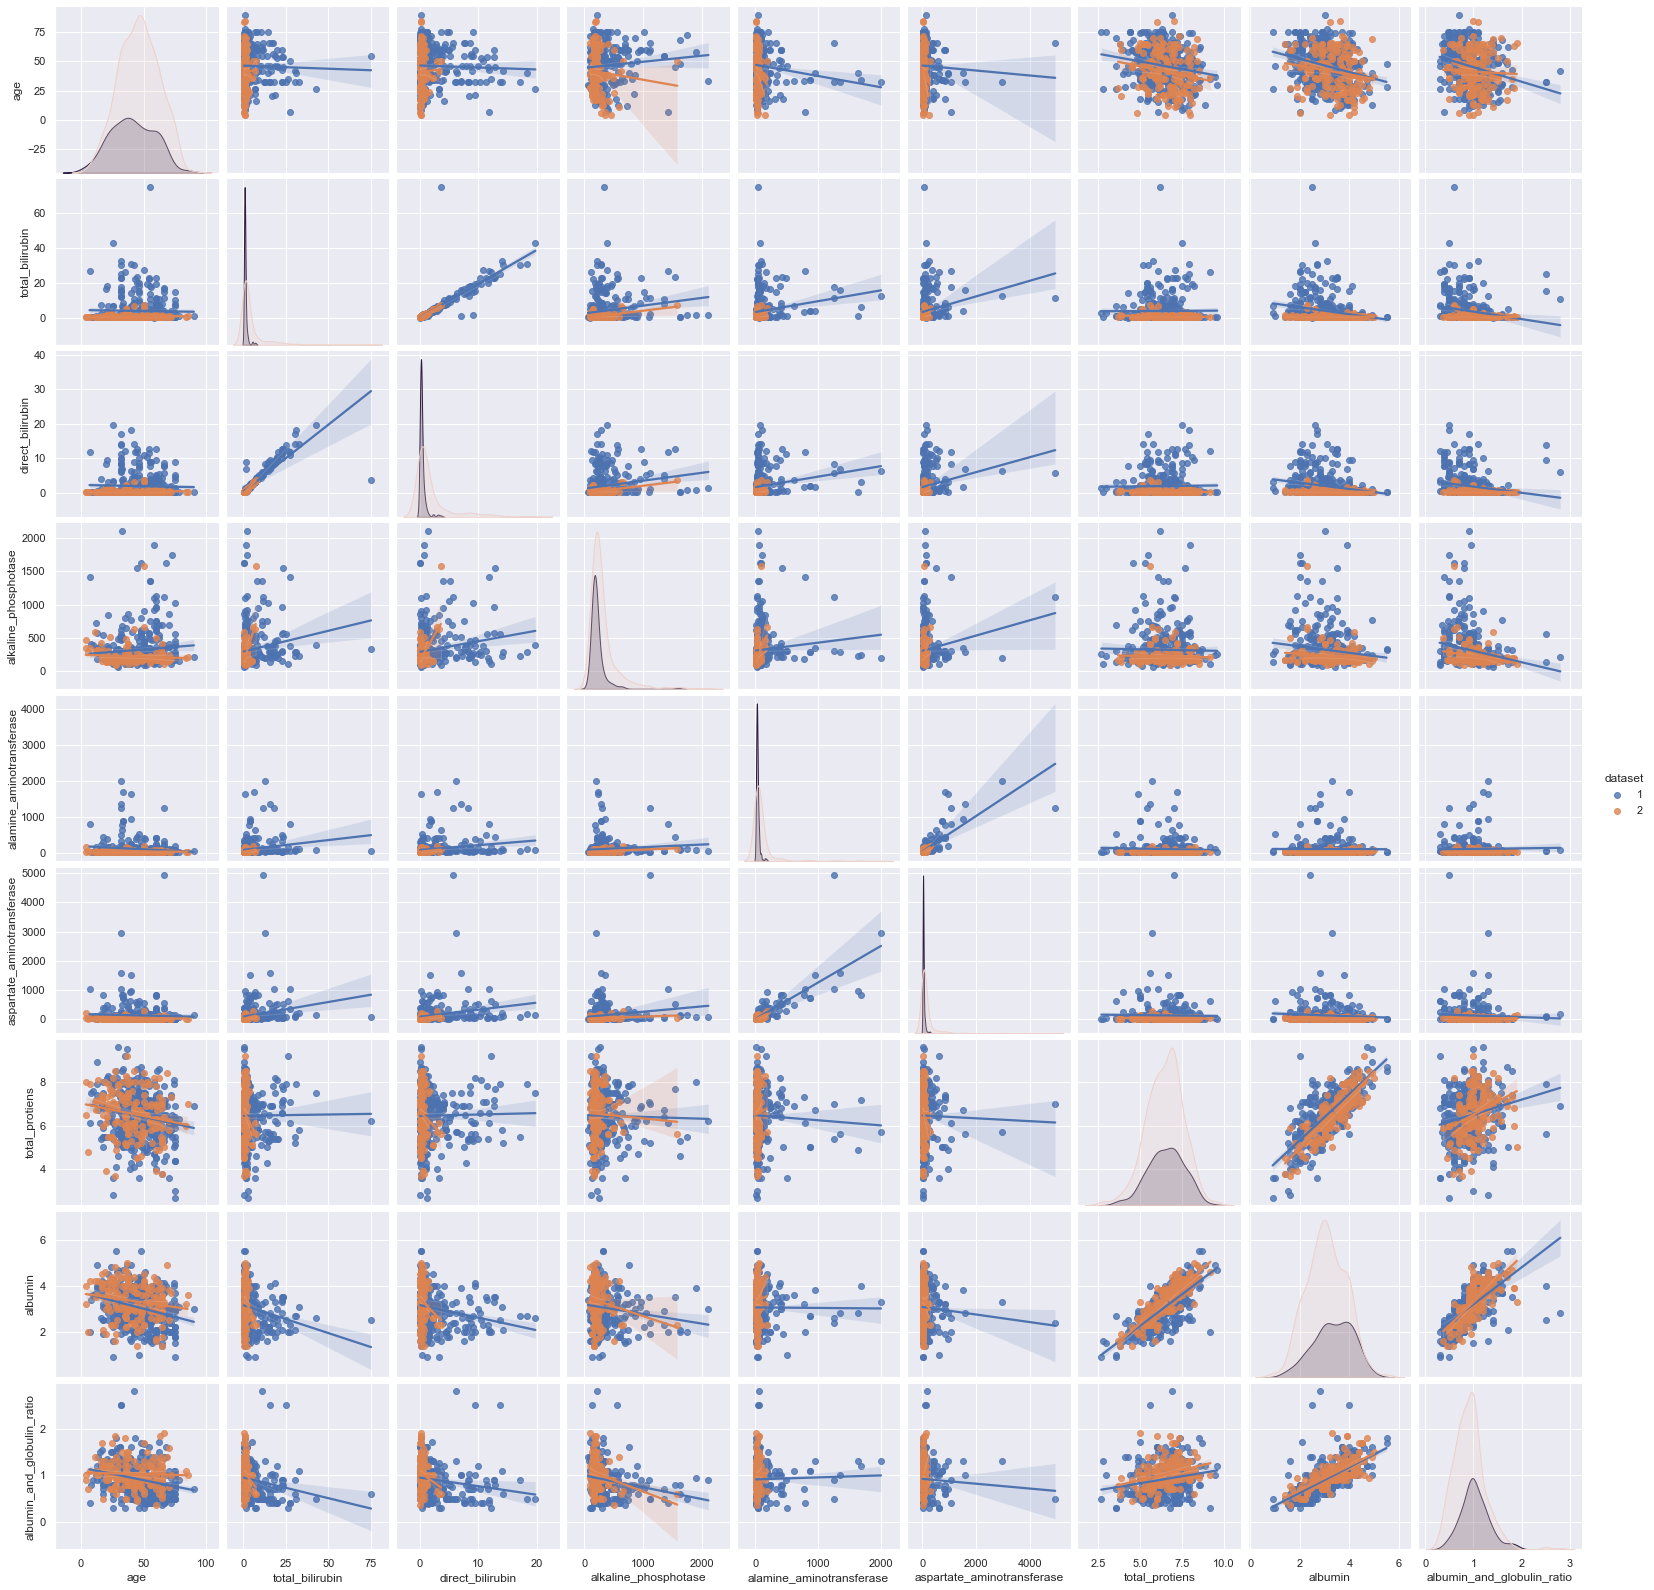

In [17]:
# correlation between variables
sns.set()
sns.pairplot(data, hue='dataset', kind='reg')

In [18]:
# correlation with datase - target value
data.corr()['dataset']

age                          -0.137351
total_bilirubin              -0.220208
direct_bilirubin             -0.246046
alkaline_phosphotase         -0.184866
alamine_aminotransferase     -0.163416
aspartate_aminotransferase   -0.151934
total_protiens                0.035008
albumin                       0.161388
albumin_and_globulin_ratio    0.162319
dataset                       1.000000
Name: dataset, dtype: float64

In [19]:
# Full correlation table
data.corr().style.background_gradient(cmap='viridis')

There is strong correlation between
 
* direct_bilirubin & total_bilirubin
* aspartate_aminotransferase & alamine_aminotransferase
* total_protiens & albumin
* albumin_and_globulin_ratio & albumin

We will drop some of them as features should be independent.

In [21]:
data.drop(['direct_bilirubin', 'aspartate_aminotransferase', 'total_protiens', 'albumin'], axis=1, inplace=True)

#### Outliers and transformations

In [41]:
# outlier check
plt.figure(figsize=(15,20))

for i, c in enumerate(data.drop('dataset', axis=1).select_dtypes(include='number').columns):
    plt.rcParams['figure.dpi'] = 500
    plt.subplot(10,2, i*2+1)
    sns.boxplot(data[c], color='blue')
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


    plt.subplot(10,2, i*2+2)
    sns.boxplot(data[c], color='red')
    plt.title('Log1p distribution plot for field' +c )
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

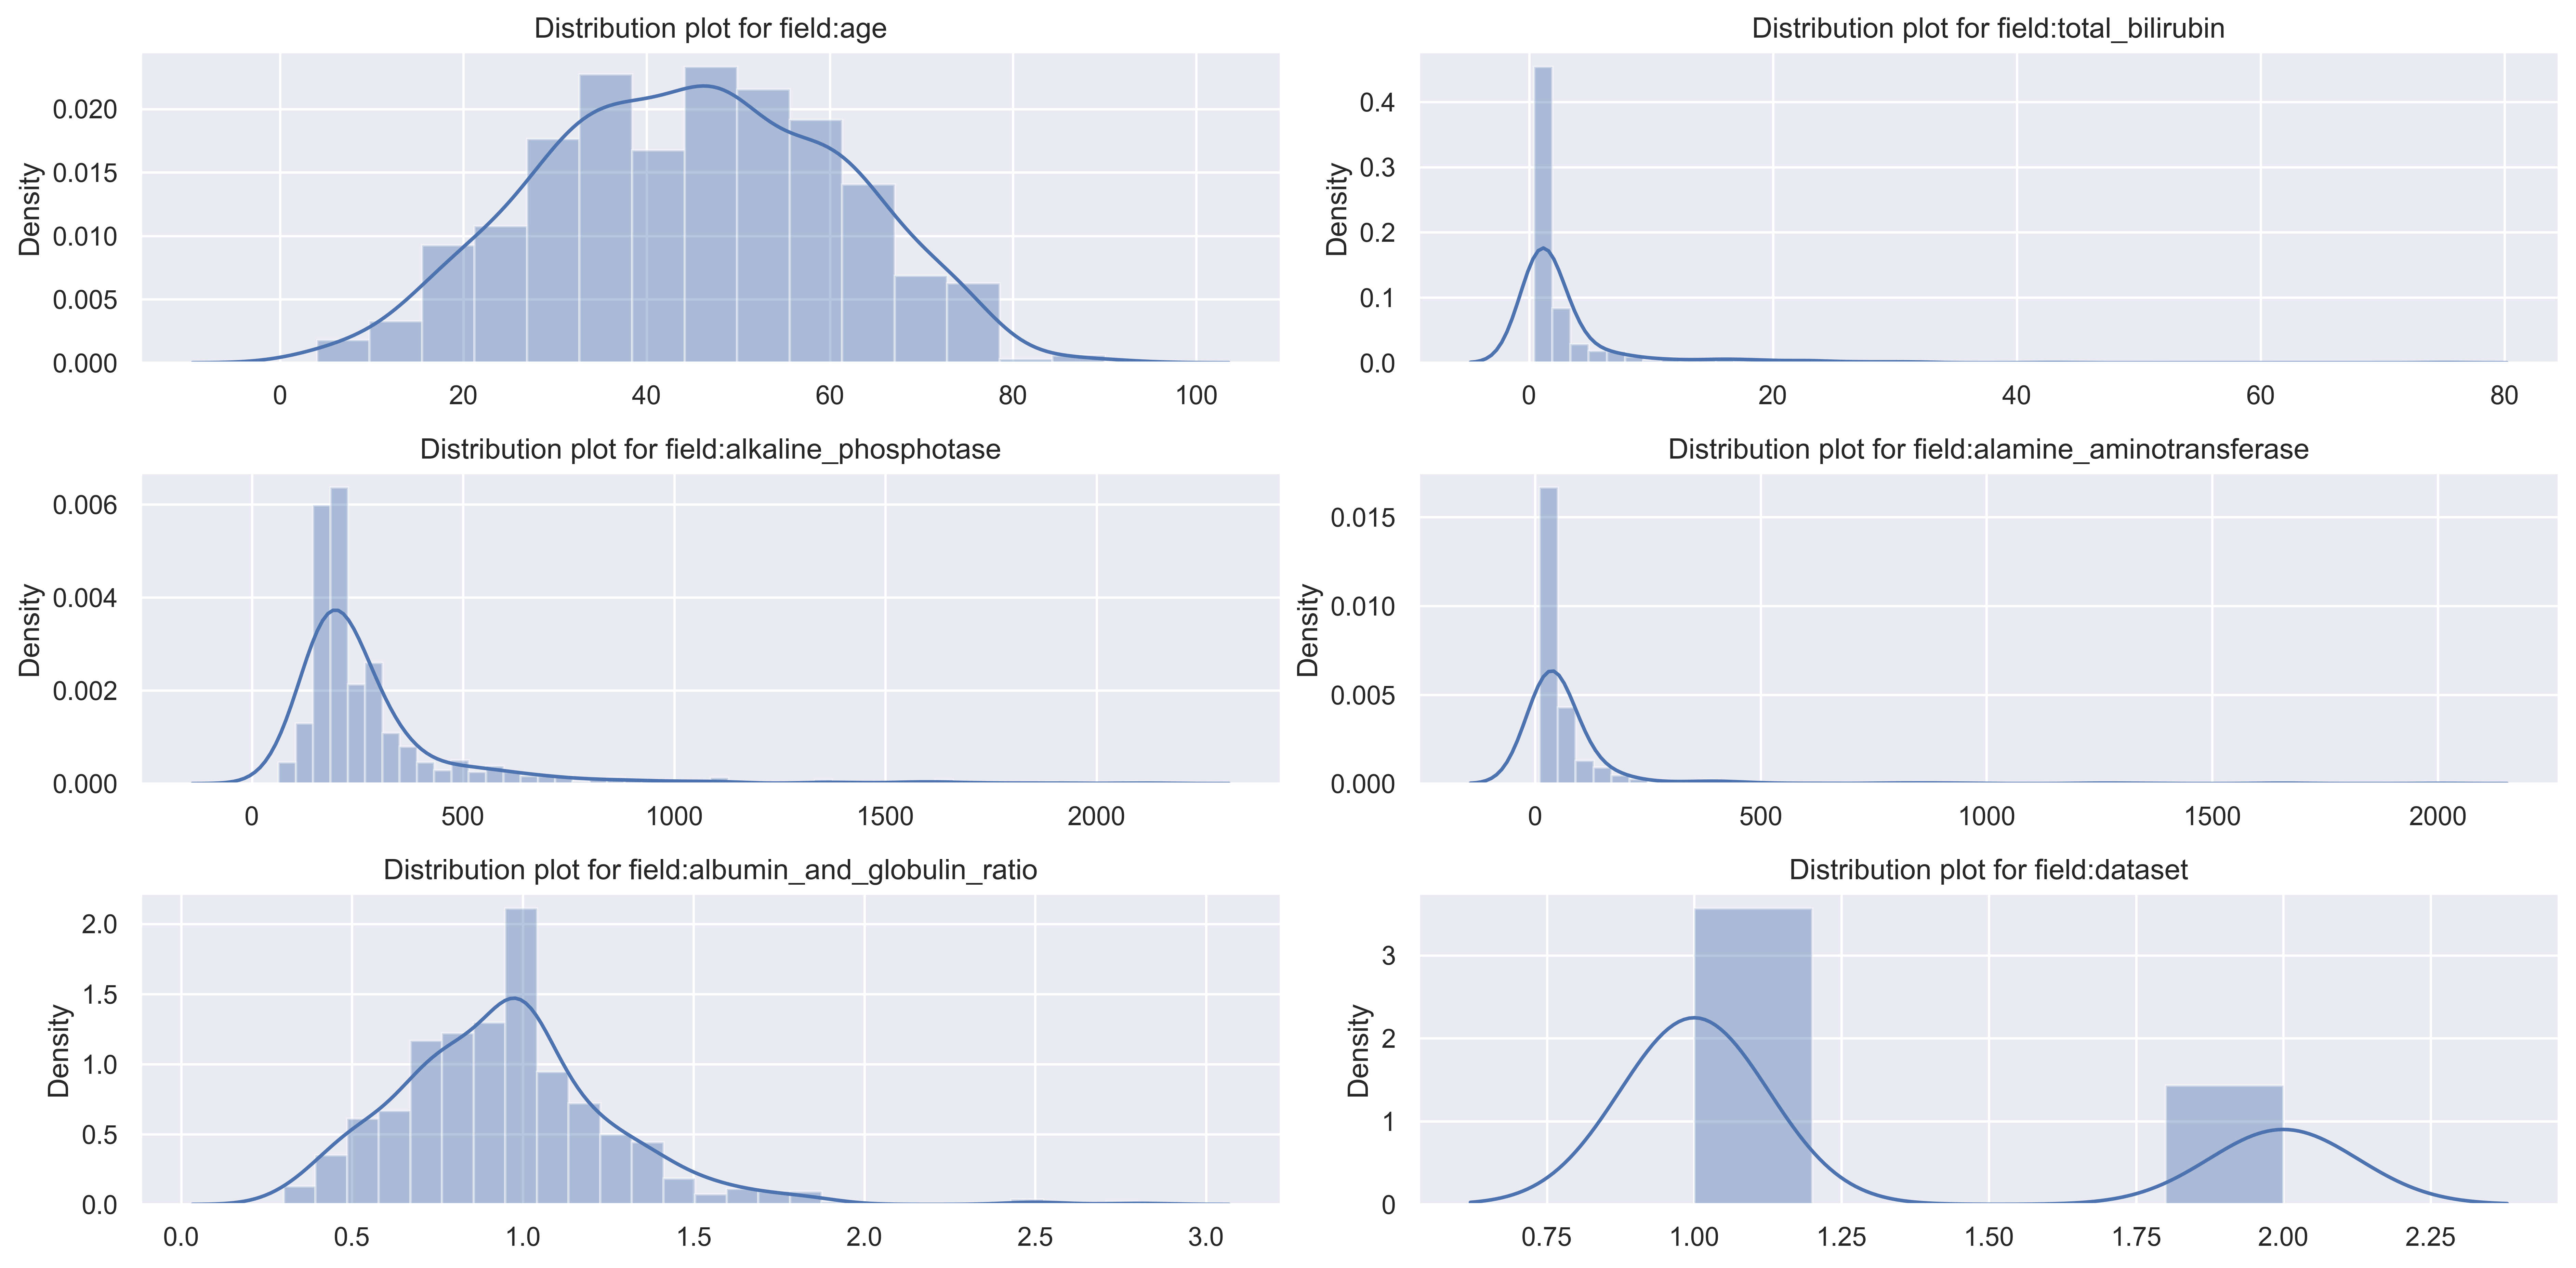

In [60]:
plt.figure(figsize=(15,12))

for i, c in enumerate(data.select_dtypes(include='number').columns):
    plt.subplot(5,2, i+1)
    sns.distplot(data[c])
    plt.title('Distribution plot for field:' + c )
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

What we learned from dis plot and box plot

* dataset is slightly imbalanced
* slightly skewed features: albumin_and_globulin_ration
* strongly skewed features: total_bilirubin, direct_bilirubin, alkaline_phosphotase, alamine_aminotransferase, aspartate_aminotransferase

#### Fixing the skewed features

In [64]:
# save skewed features
skewed_cols = ['albumin_and_globulin_ratio', 'total_bilirubin','alkaline_phosphotase','alamine_aminotransferase']


In [65]:
# Apply log1p transofrmation on dataframe - just selected values
for c in skewed_cols:
    data[c] = data[c].apply('log1p')

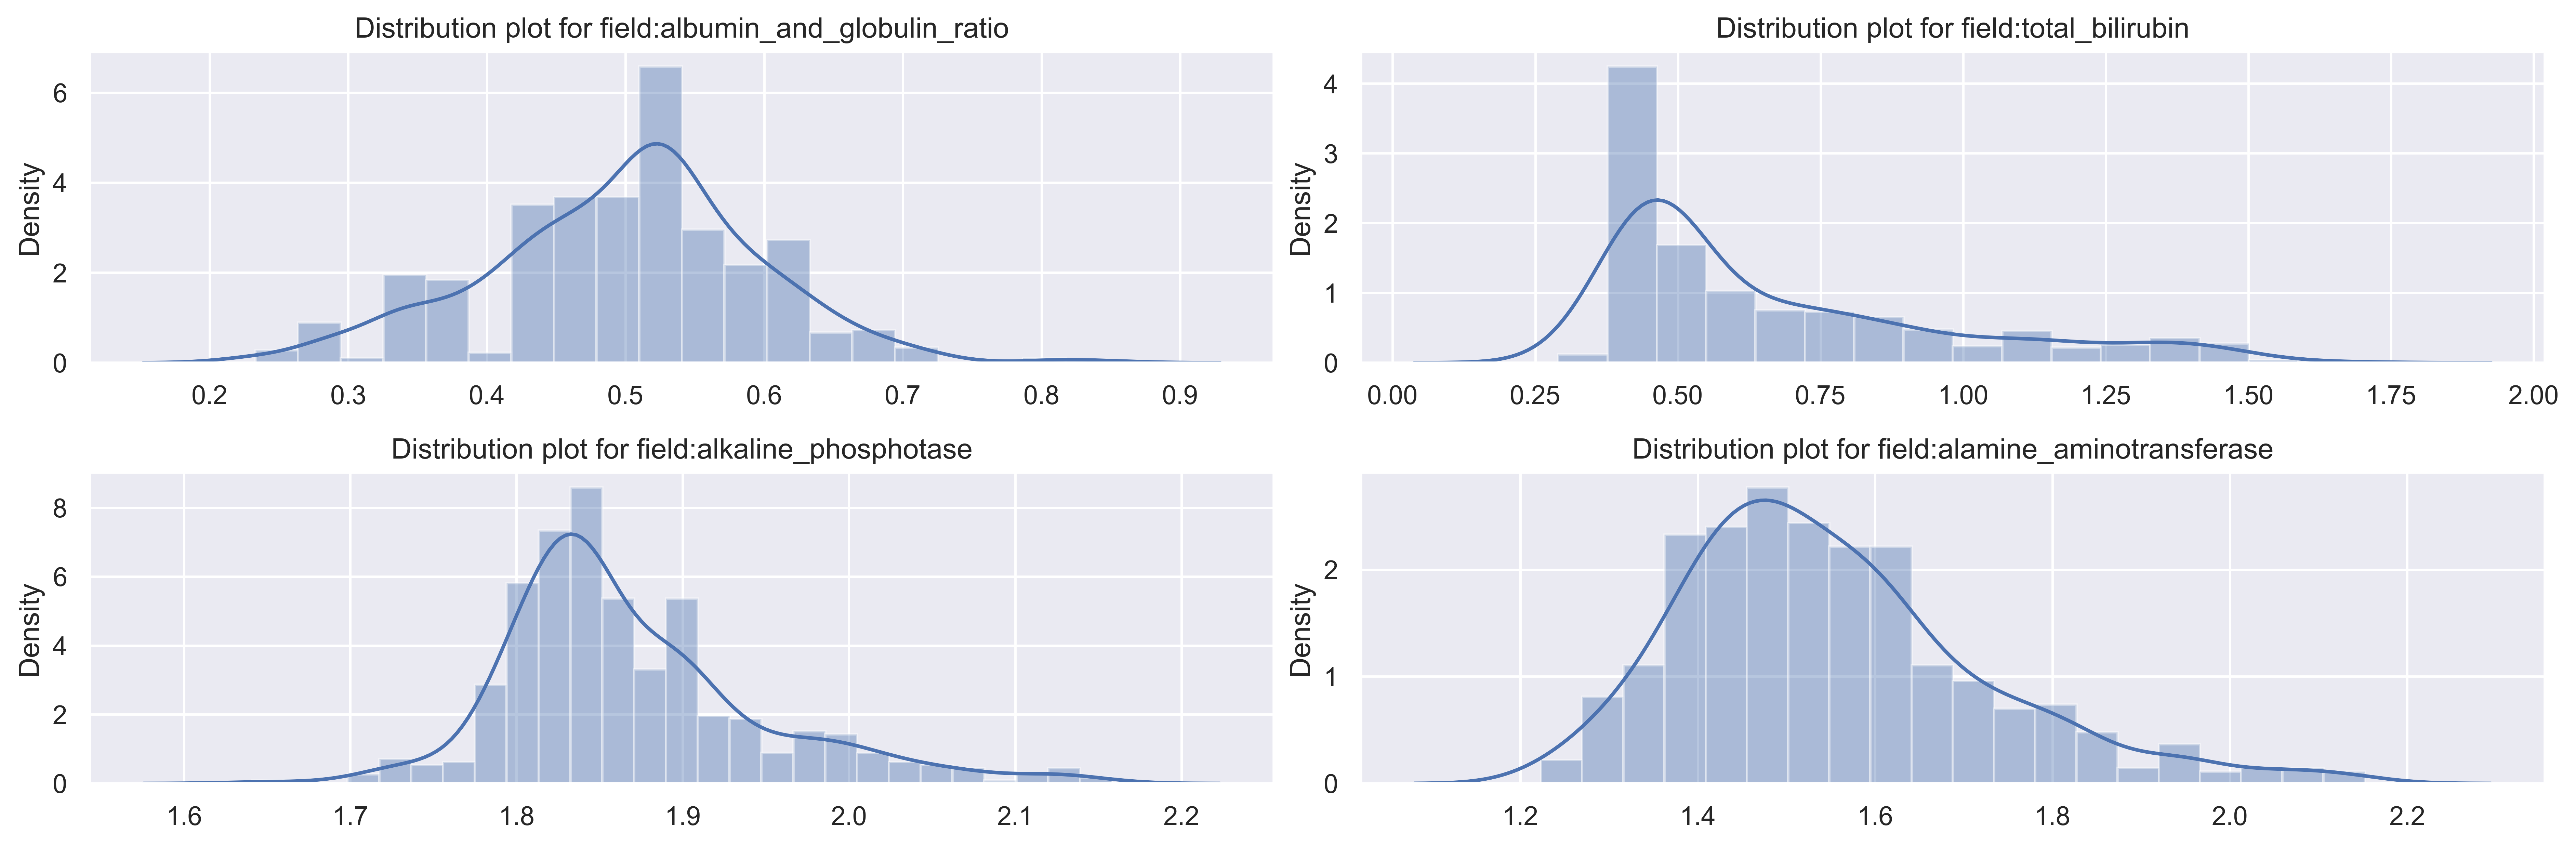

In [67]:
# Check the skewd feature again
plt.figure(figsize=(15,12))

for i, c in enumerate(skewed_cols):
    plt.subplot(5,2,i+1)
    sns.distplot(data[c].apply(np.log1p))
    plt.title('Distribution plot for field:'+ c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#### Encode and Scale 

In [69]:
# The Gender column contian string value Male , Female. These will be converted into 0,1
le = LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])
data.gender.head()

0    0
1    1
2    1
3    1
4    1
Name: gender, dtype: int64

In [71]:
rs = RobustScaler()
for c in data[['age', 'gender', 'total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'albumin_and_globulin_ratio']].columns:
    data[c] = rs.fit_transform(data[c].values.reshape(-1,1))
data.head()

age  gender  total_bilirubin  alkaline_phosphotase  \
0  0.80    -1.0        -0.234465             -0.200886   
1  0.68     0.0         2.572890              2.293084   
2  0.68     0.0         2.053111              1.620312   
3  0.52     0.0         0.000000             -0.252023   
4  1.08     0.0         1.292782             -0.121830   

   alamine_aminotransferase  albumin_and_globulin_ratio  dataset  
0                 -0.797391                   -0.115796        1  
1                  0.627949                   -0.532099        1  
2                  0.560449                   -0.140769        1  
3                 -0.930409                    0.126945        1  
4                 -0.267086                   -1.560985        1

#### Balance Data

In [75]:
# Check the balance of data
data.dataset.value_counts()

1    416
2    167
Name: dataset, dtype: int64

In [77]:
# split data on majority and minority
minority = data[data.dataset == 2]
majority = data[data.dataset == 1]

print('Minority size:', minority.shape)
print('Majority size:', majority.shape)

Minority size: (167, 7)
Majority size: (416, 7)


In [78]:
# choosing upsample as enven now we do not have too much data
minority_upsample = resample(minority, replace=True, n_samples=majority.shape[0])
print('Minority upsampled size:', minority_upsample.shape)

Minority upsampled size: (416, 7)


In [81]:
# merge majority with upsampled minority
data = pd.concat([minority_upsample, majority], axis=0)

#### Split data for modeling

This is very needed in order to be able to compare performance of model on unseen data. I will choose test size to be 0.25. Dataset is also split to X (features) and y (target) variables.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('dataset', axis=1), data['dataset'], test_size=0.25, random_state=123)
print('Train values shape:', X_train.shape)
print('Test values shape:', X_test.shape)
print('Train target shape:', y_train.shape)
print('Test target shape:',y_test.shape)

Train values shape: (624, 6)
Test values shape: (208, 6)
Train target shape: (624,)
Test target shape: (208,)


### Modle selection

We will use several popular models and see how they perform on our dataset. At the end we choose 3 best performing models and will merge them together.

##### Logistic Regression

In [96]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('----------------------------------------------------')
print(classification_report(y_train, y_train_hat))


print('Test performance')
print('----------------------------------------------------')
print(classification_report(y_test, y_test_hat))


print('Roc_auc_score')
print('----------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('confusion_matrix')
print('----------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


LogisticRegression()
Train performance
----------------------------------------------------
              precision    recall  f1-score   support

           1       0.79      0.67      0.73       313
           2       0.71      0.82      0.76       311

    accuracy                           0.75       624
   macro avg       0.75      0.75      0.75       624
weighted avg       0.75      0.75      0.75       624

Test performance
----------------------------------------------------
              precision    recall  f1-score   support

           1       0.77      0.50      0.60       103
           2       0.63      0.86      0.73       105

    accuracy                           0.68       208
   macro avg       0.70      0.68      0.67       208
weighted avg       0.70      0.68      0.67       208

Roc_auc_score
----------------------------------------------------
0.6761442441054092

confusion_matrix
----------------------------------------------------
[[51 52]
 [15 90]]


##### Support Vector Machine

In [97]:
model  = SVC()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('----------------------------')
print(classification_report(y_train, y_train_hat))


print('Test performance')
print('-----------------------------')
print(classification_report(y_test, y_test_hat))


print('Roc_auc_score')
print('-----------------------------')
print(roc_auc_score(y_test, y_test_hat))

print('Confusion_matrix')
print('-----------------------------')
print(confusion_matrix(y_test,y_test_hat))

SVC()
Train performance
----------------------------
              precision    recall  f1-score   support

           1       0.87      0.62      0.72       313
           2       0.70      0.91      0.79       311

    accuracy                           0.76       624
   macro avg       0.79      0.76      0.76       624
weighted avg       0.79      0.76      0.76       624

Test performance
-----------------------------
              precision    recall  f1-score   support

           1       0.79      0.43      0.55       103
           2       0.61      0.89      0.72       105

    accuracy                           0.66       208
   macro avg       0.70      0.66      0.64       208
weighted avg       0.70      0.66      0.64       208

Roc_auc_score
-----------------------------
0.6564493758668516
Confusion_matrix
-----------------------------
[[44 59]
 [12 93]]
